In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
reviews = pd.read_csv('../Data/BlackMyth.csv')

In [4]:
reviews.head()

,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,written_during_early_access,primarily_steam_deck,timestamp_created,review
0,1166,0,21,0,1,0.500000,0,True,False,False,2025-05-17 12:39:58,it beatuful game if you dont playing it it loo...
1,190,0,20,1,3,0.476378,0,True,False,False,2025-05-17 12:20:23,not fan of playing as monkey
2,2928,0,3,1,0,0.500000,0,True,False,False,2025-05-17 10:24:23,all the tigers can get fucked yellow loong gav...
3,5260,106,14,0,0,0.500000,0,True,False,False,2025-05-17 07:18:38,one of the best games ever played genuine game...
4,17522,33,2,0,0,0.500000,0,True,False,False,2025-05-17 05:13:24,perfect visuals and challenging journey


In [4]:
reviews.shape

(39015, 14)

In [5]:
reviews.drop(columns=["polarity_score", "primarily_steam_deck", "timestamp_created"], inplace=True)

In [5]:
reviews.head(1)

,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,written_during_early_access,primarily_steam_deck,timestamp_created,review
0,1166,0,21,0,1,0.5,0,True,False,False,2025-05-17 12:39:58,it beatuful game if you dont playing it it loo...


# Feature Visualization

In [6]:
reviews.describe()

,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count
count,36571.000000,36571.000000,36571.000000,36571.000000,36571.000000,36571.000000,36571.00000
mean,3863.626343,88.839463,13.846217,2.441279,0.370457,0.500184,0.10954
std,4223.941437,295.383785,28.869221,74.083772,10.754685,0.031564,1.78949
min,5.000000,0.000000,1.000000,0.000000,0.000000,0.067203,0.00000
25%,1572.500000,0.000000,2.000000,0.000000,0.000000,0.500000,0.00000
50%,3166.000000,0.000000,5.000000,0.000000,0.000000,0.500000,0.00000
75%,4942.500000,72.000000,14.000000,1.000000,0.000000,0.500000,0.00000
max,283175.000000,24228.000000,1182.000000,8196.000000,1560.000000,0.971076,205.00000


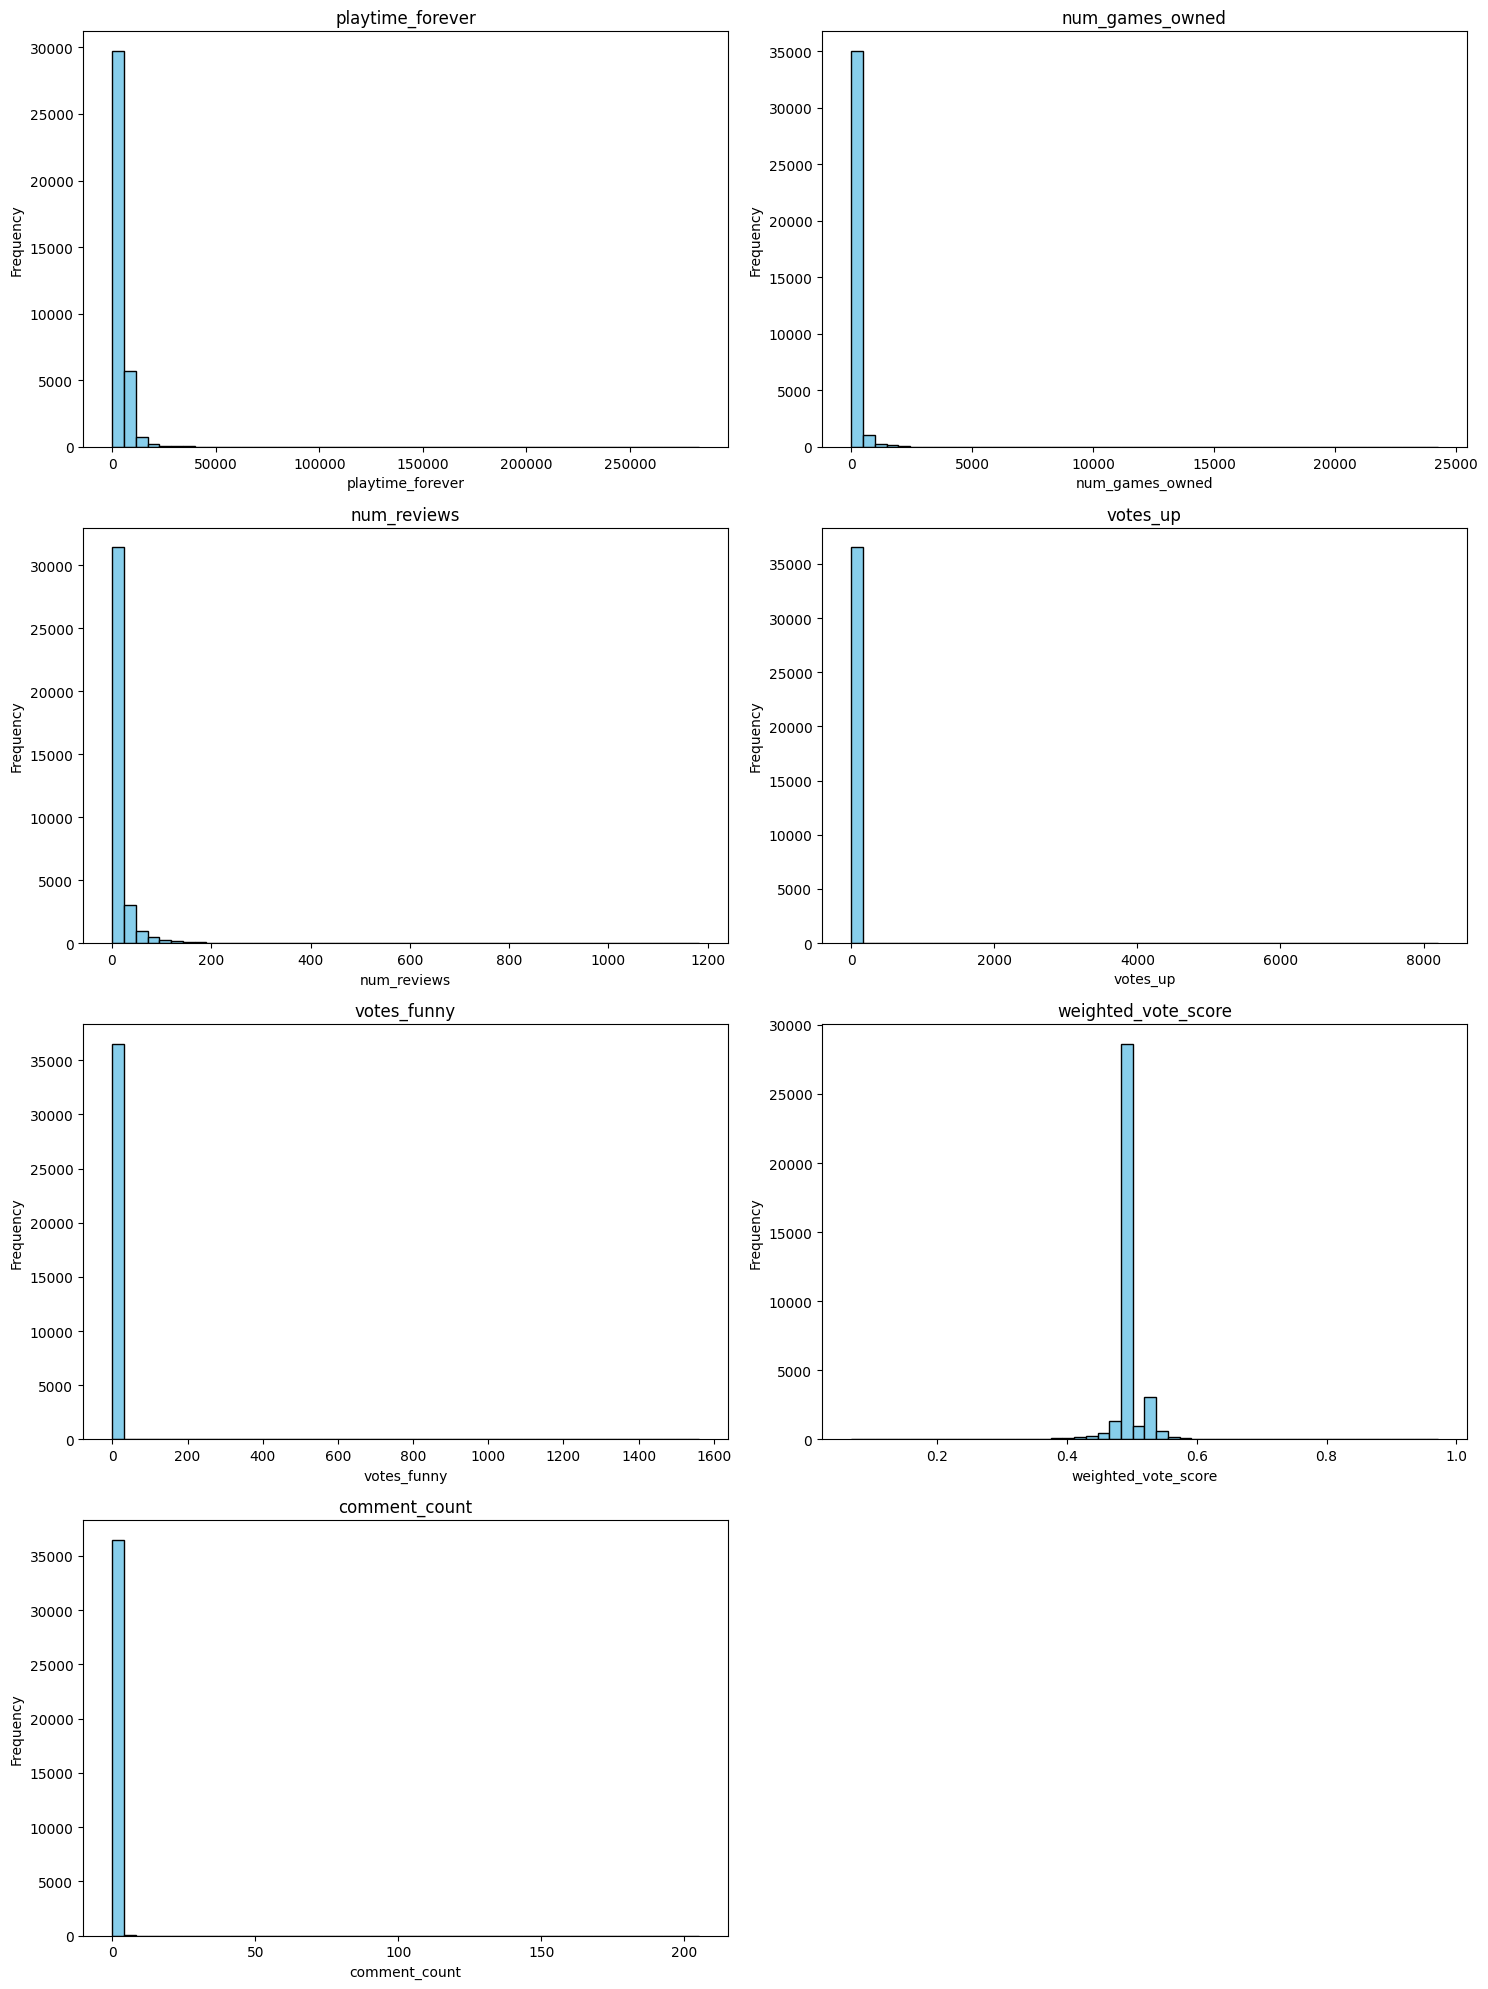

In [7]:
# plot histograms for all features

fig, axes = plt.subplots(4, 2, figsize=(15, 20)) 
axes = axes.flatten() 

cols = ['playtime_forever', 'num_games_owned', 'num_reviews', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count']
for i, col in enumerate(cols):
    axes[i].hist(reviews[col], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel('Frequency')

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

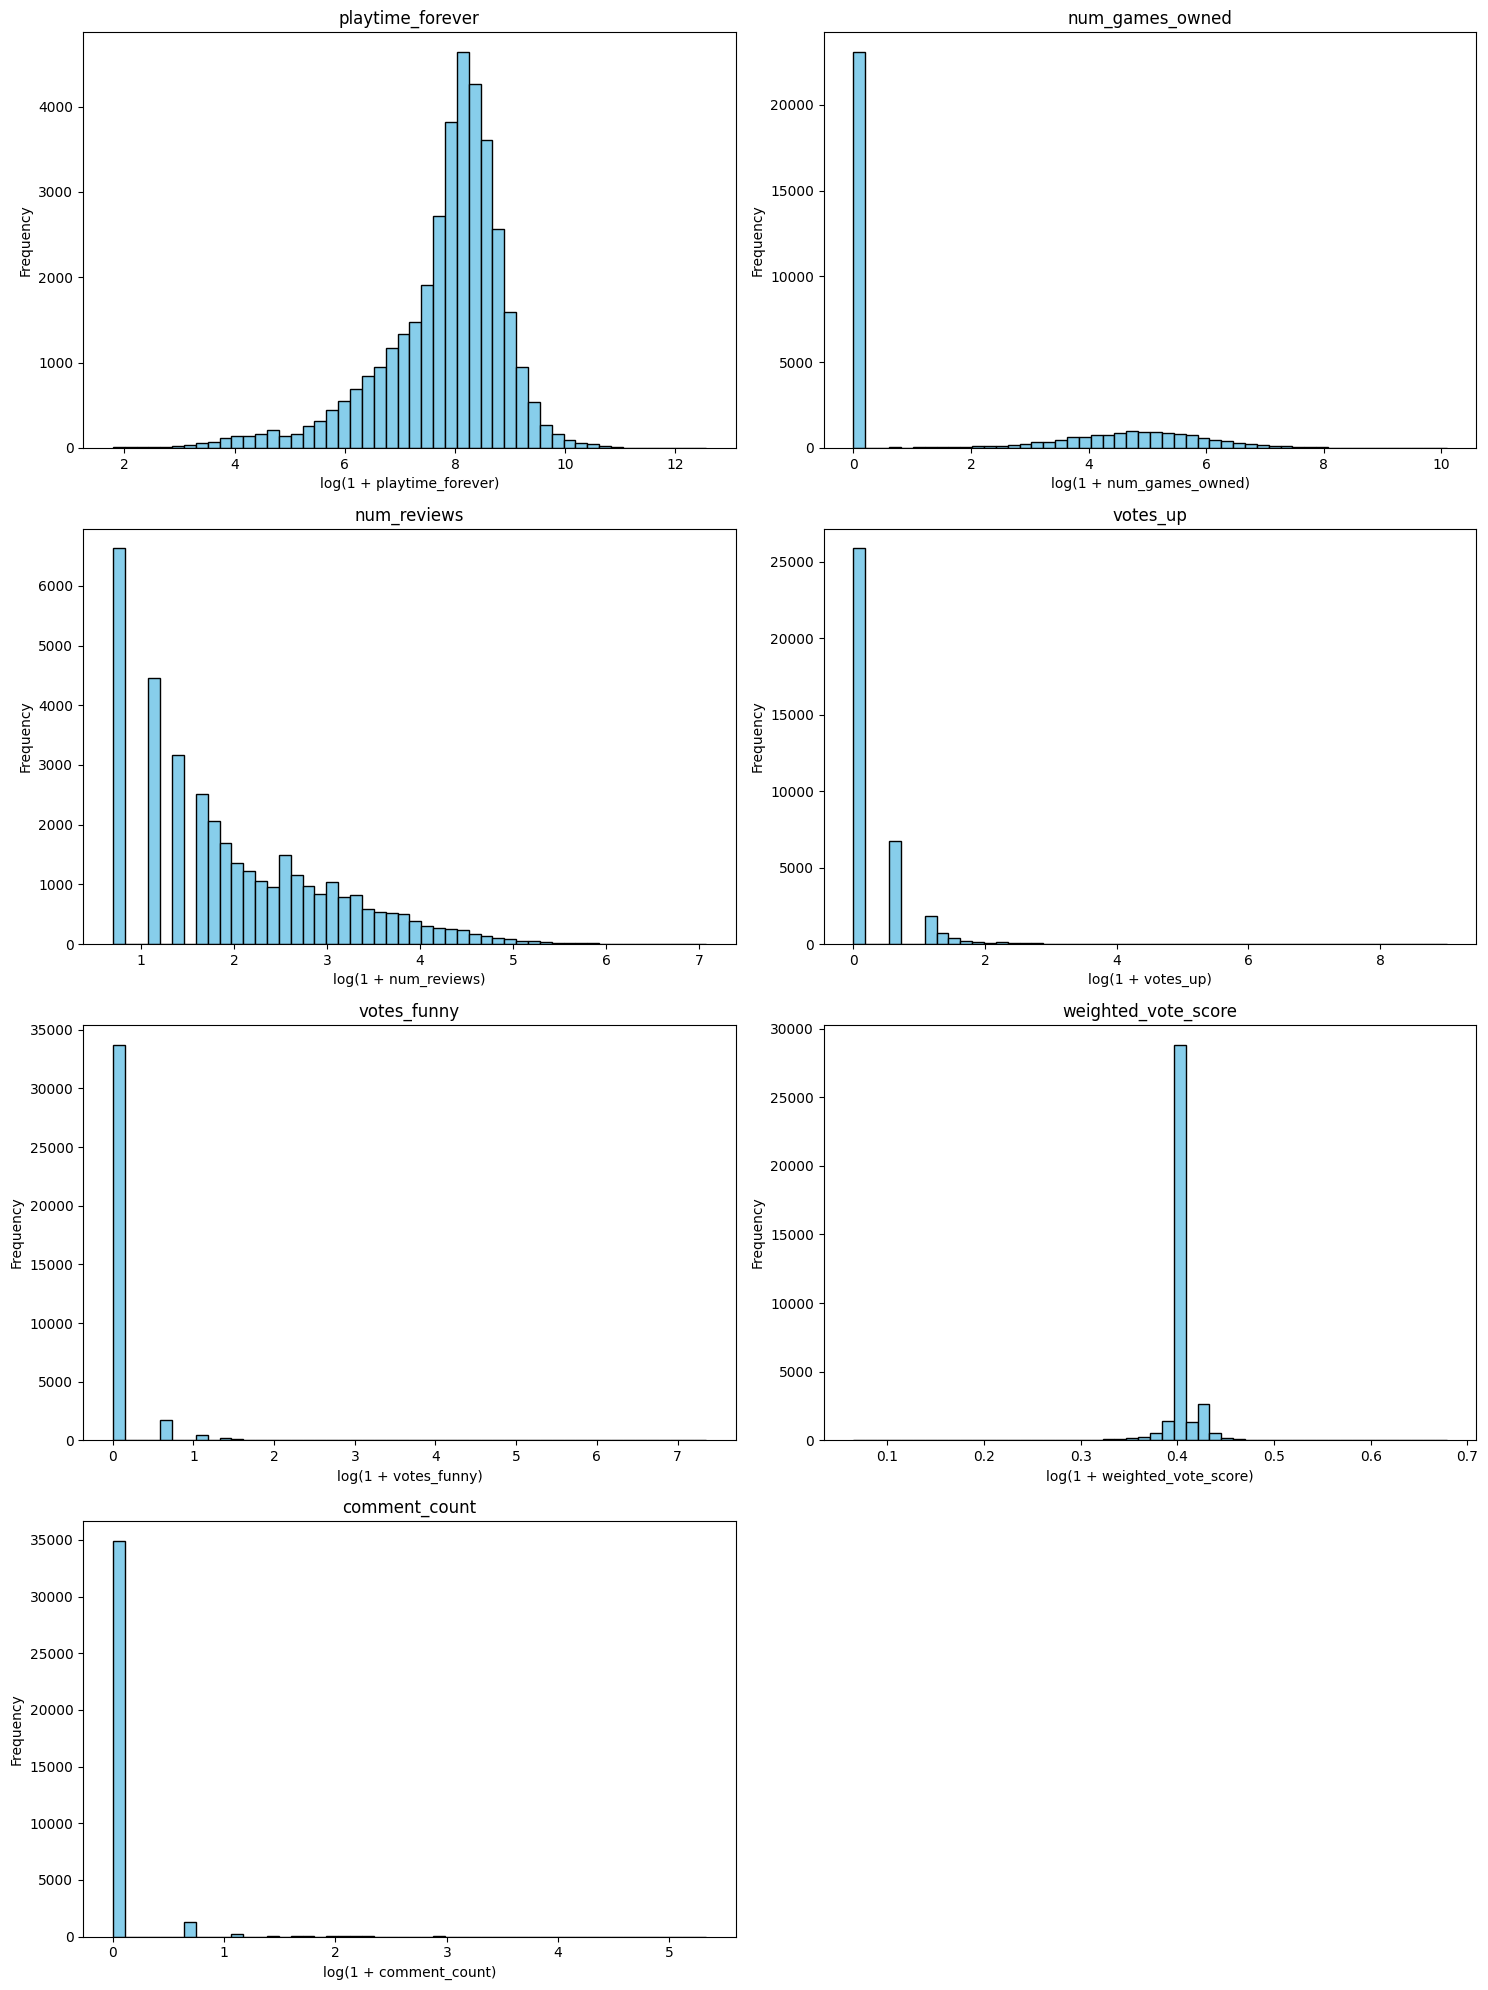

In [8]:
# apply log transformation to features because of skewed distribution

fig, axes = plt.subplots(4, 2, figsize=(15, 20)) 
axes = axes.flatten() 

for i, col in enumerate(cols):
    axes[i].hist(np.log1p(reviews[col]), bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(f'log(1 + {col})')
    axes[i].set_ylabel('Frequency')


if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

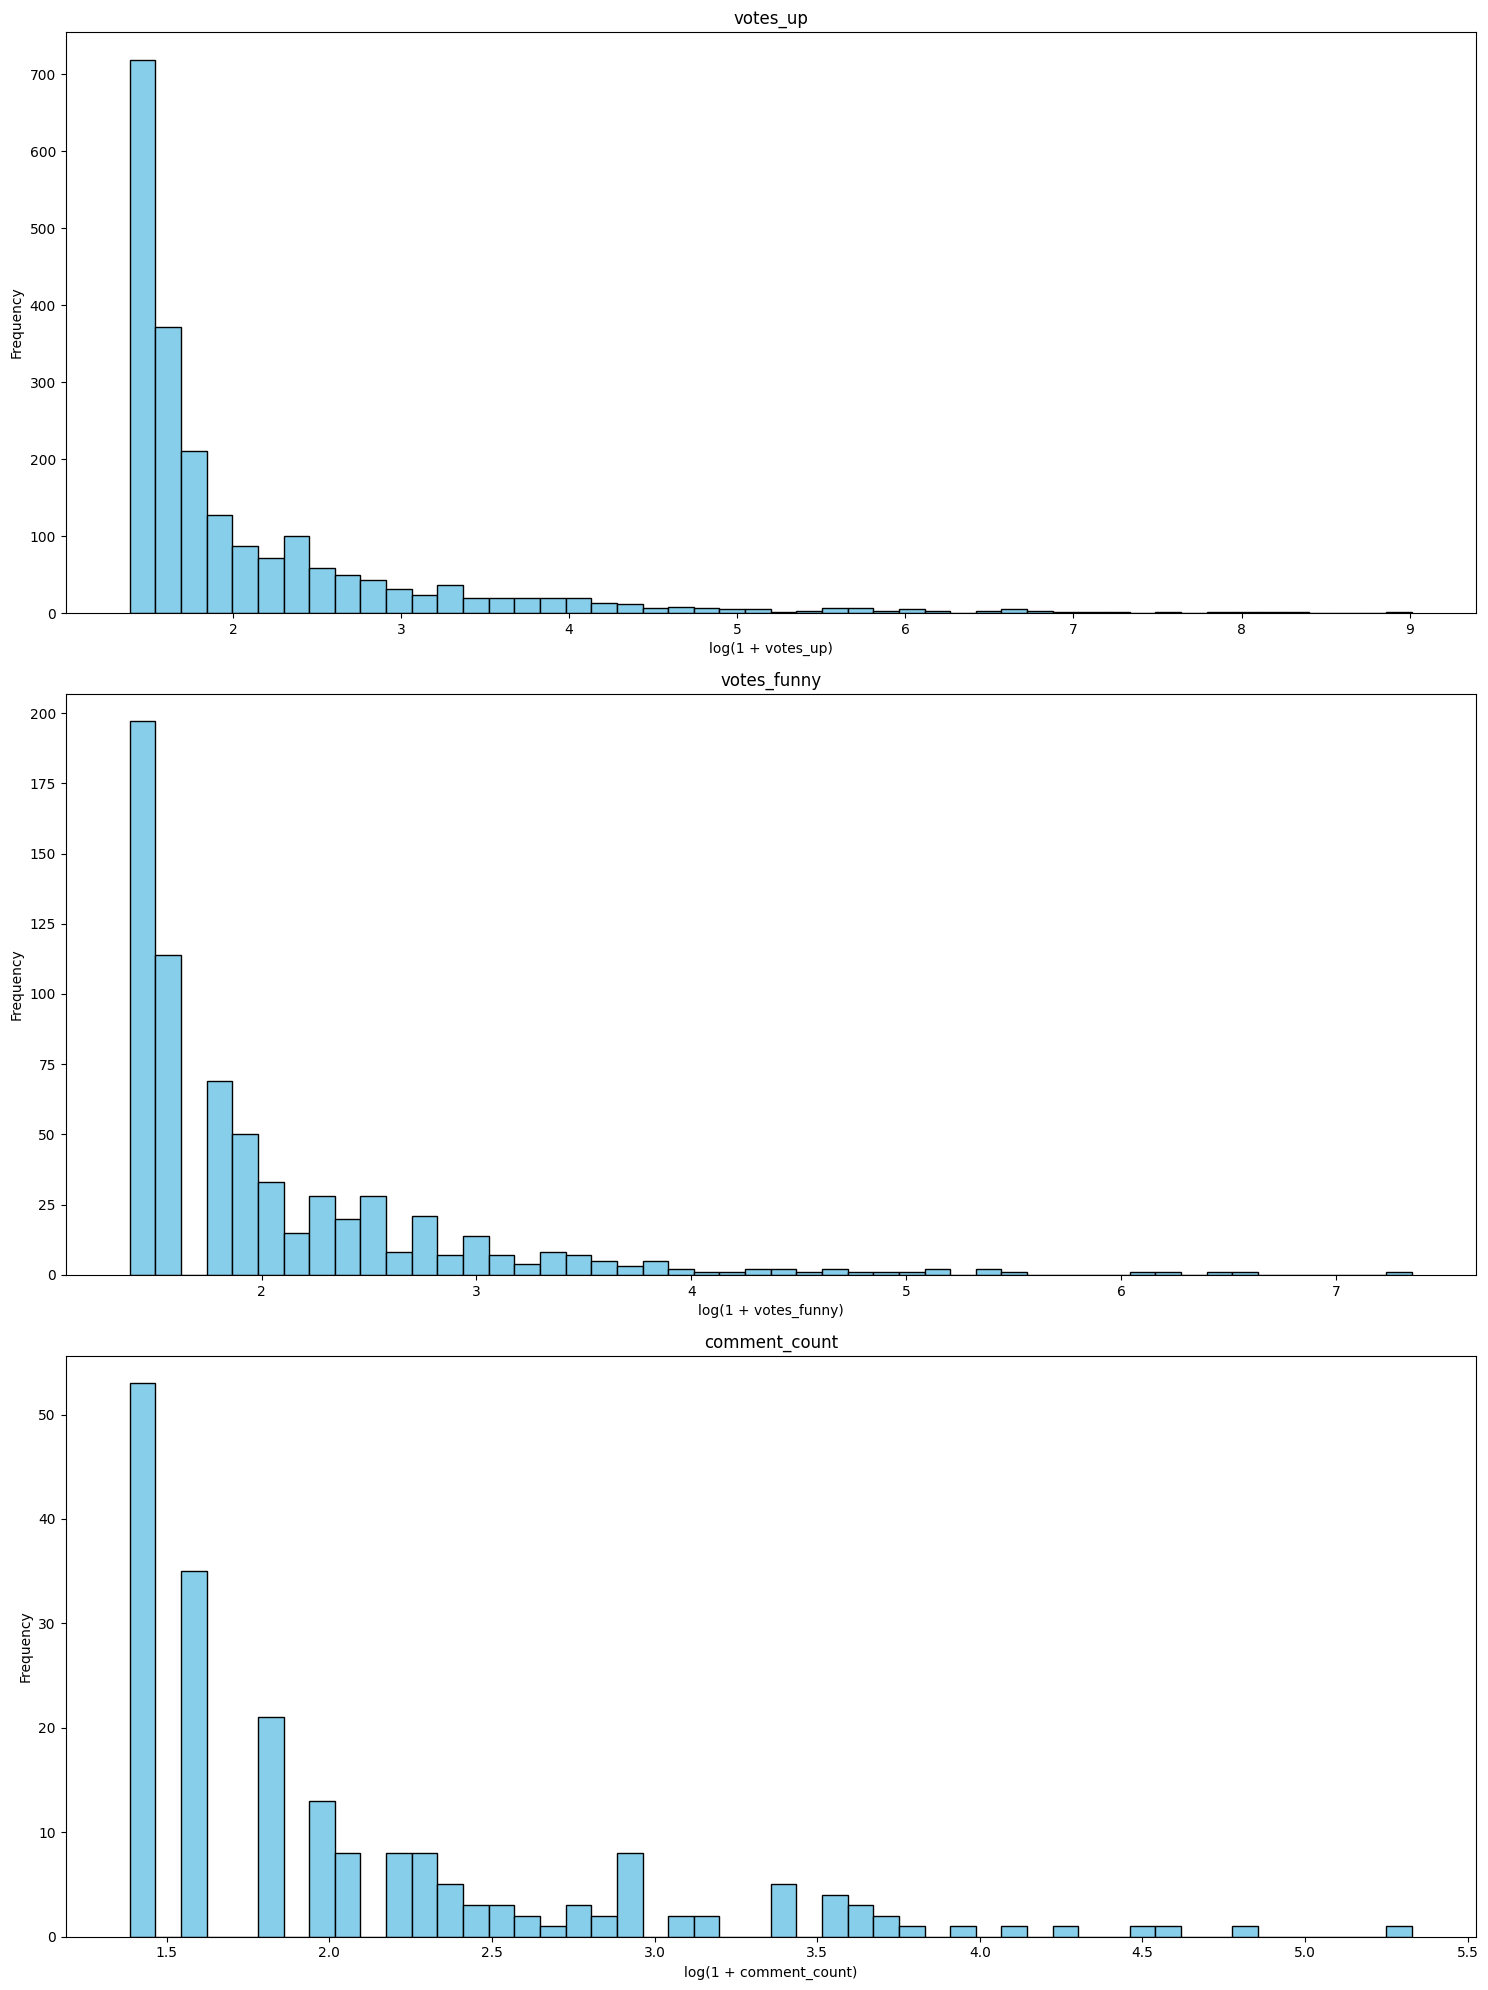

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20)) 
axes = axes.flatten() 

nonzero_cols = ['votes_up', 'votes_funny', 'comment_count']

for i, col in enumerate(nonzero_cols):
    axes[i].hist(np.log1p(reviews[col][reviews[col] > 2]), bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(f'log(1 + {col})')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

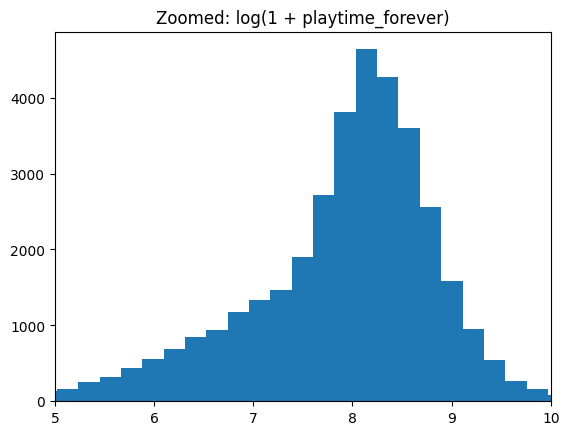

In [10]:
plt.hist(np.log1p(reviews['playtime_forever']), bins=50)
plt.xlim(5, 10)  
plt.title('Zoomed: log(1 + playtime_forever)')
plt.show()

# Heuristic Labeling

In [11]:
## <10 minutes played is at extreme tail. weighted_vote_score > 0.96
## is unusually high for such a short amount of playtime
## votes_up = 0 means no one agreed with such a strong sentiment

rule1 = (
    (reviews['playtime_forever'] < 10) &
    (reviews['weighted_vote_score'] > 0.96) &
    (reviews['votes_up'] == 0)
)



rule2 = (
    (reviews['num_games_owned'] > 500) &
    (reviews['playtime_forever'] < 30)
)

## 500+ games is top 1%
## fake accounts play tons of games so if user has that many games and plays less than 30 minutes for each it is suspicious

rule3 = (
    (reviews['num_reviews'] > 100) &
    (reviews['votes_up'] < 2)
)

## num_reviews = 100 is the 99th percentile
## most real users mainly write a few reviews

rule4 = (
    (reviews['weighted_vote_score'] > 0.97) &
    (reviews['votes_up'] == 0) &
    (reviews['comment_count'] == 0) &
    (reviews['playtime_forever'] < 10)
)

## weighted_vote_score > 0.97 is at extreme tail end
## doesn't make sense if weighted_vote_score is this high but the review receives no engagement

rule5 = (
    (reviews['num_reviews'] > np.percentile(reviews['num_reviews'], 99)) &
    (reviews['votes_up'] == 0)
)

## num_reviews is greater than 99th percentile and review receives 0 upvotes

y1 = rule1 | rule2 | rule3 | rule4 | rule5
y1 = y1.astype(int)
print("Fake rate:", y1.mean())

Fake rate: 0.011812638429356594


In [12]:
rule1 = (
    (reviews['num_reviews'] > 200) & 
    (reviews['comment_count'] == 0) & 
    (reviews['votes_up'] < 3)
)
## high number of reviews with no engagement
## could be low quality mass posting


rule2 = (
    (reviews['playtime_forever'] < 5) & 
    (reviews['votes_funny'] > 2)
)
# odd to be marked "funny" while barely playing the game
# similar to how people find a "bot" comment funny


rule3 = (
    (reviews['num_games_owned'] > 600) & 
    (reviews['playtime_forever'] < 20)
)
# top 1% of game owners but little playtime

rule4 = (
    (reviews['weighted_vote_score'] < 0.05) & 
    (reviews['votes_up'] > 10)
)
# negative score and lots of upvotes is contradictory

rule5 = (
    (reviews['num_reviews'] > 150) &
    (reviews['playtime_forever'] < 15)
)
# writing many reviews without actual gameplay

y2 = rule1 | rule2 | rule3 | rule4 | rule5
y2 = y2.astype(int)
print("Fake rate:", y2.mean())

Fake rate: 0.002542998550764267


In [13]:
rule1 = (
    (reviews['playtime_forever'] < 10) &
    (reviews['weighted_vote_score'] > 0.95) &
    (reviews['votes_up'] == 0)
)

rule2 = (
    (reviews['num_games_owned'] > 500) &
    (reviews['playtime_forever'] < 30)
)

rule3 = (
    (reviews['num_reviews'] > 50) &  
    (reviews['votes_up'] < 1)
)

rule4 = (
    (reviews['weighted_vote_score'] > 0.97) &
    (reviews['votes_up'] == 0) &
    (reviews['comment_count'] == 0) &
    (reviews['playtime_forever'] < 15)
)

rule5 = (
    (reviews['num_reviews'] > np.percentile(reviews['num_reviews'], 98)) &
    (reviews['votes_up'] == 0)
)

rule6 = (
    (reviews['comment_count'] > 10) &
    (reviews['votes_funny'] > 100) & 
    (reviews['weighted_vote_score'] < 0.1)
)

y3 = rule1 | rule2 | rule3 | rule4 | rule5 | rule6
y3 = y3.astype(int)
print("Fake rate:", y3.mean())

Fake rate: 0.030789423313554456


In [14]:
rule1 = (
    (reviews['playtime_forever'] < 20) & 
    (reviews['weighted_vote_score'] > 0.94) & 
    (reviews['votes_up'] <= 1)
)

rule2 = (
    (reviews['num_games_owned'] > 300) & 
    (reviews['playtime_forever'] < 60)
)

rule3 = (
    (reviews['num_reviews'] > 30) & 
    (reviews['votes_up'] < 1)
)

rule4 = (
    (reviews['weighted_vote_score'] > 0.96) & 
    (reviews['votes_up'] == 0) & 
    (reviews['comment_count'] == 0) & 
    (reviews['playtime_forever'] < 20)
)

rule5 = (
    (reviews['num_reviews'] > np.percentile(reviews['num_reviews'], 97)) & 
    (reviews['votes_up'] <= 1)
)

rule6 = (
    (reviews['votes_funny'] > 50) & 
    (reviews['weighted_vote_score'] < 0.1)
)

rule7 = (
    (reviews['comment_count'] == 0) & 
    (reviews['votes_up'] == 0) & 
    (reviews['weighted_vote_score'] > 0.97)
)

y4 = rule1 | rule2 | rule3 | rule4 | rule5 | rule6
y4 = y4.astype(int)
print("Fake rate:", y4.mean())

Fake rate: 0.07237975445024747


In [15]:
rule1 = (
    (reviews['playtime_forever'] < 30) &
    (reviews['weighted_vote_score'] > 0.93) &
    (reviews['votes_up'] <= 1)
)

rule2 = (
    (reviews['num_games_owned'] > 250) &
    (reviews['playtime_forever'] < 80)
)

rule3 = (
    (reviews['num_reviews'] > 25) &
    (reviews['votes_up'] < 2)
)

rule4 = (
    (reviews['weighted_vote_score'] > 0.96) &
    (reviews['votes_up'] <= 1) &
    (reviews['comment_count'] <= 1) &
    (reviews['playtime_forever'] < 30)
)

rule5 = (
    (reviews['num_reviews'] > np.percentile(reviews['num_reviews'], 95)) &
    (reviews['votes_up'] <= 1)
)

rule6 = (
    (reviews['votes_funny'] > 30) &
    (reviews['weighted_vote_score'] < 0.15)
)

rule7 = (
    (reviews['comment_count'] == 0) &
    (reviews['votes_up'] <= 1) &
    (reviews['weighted_vote_score'] > 0.95)
)


y5 = rule1 | rule2 | rule3 | rule4 | rule5 | rule6 |rule7
y5 = y5.astype(int)
print("Fake rate:", y5.mean())

Fake rate: 0.11123567854310792


In [16]:
rule1 = (
    (reviews['playtime_forever'] < 45) &
    (reviews['weighted_vote_score'] > 0.92) &
    (reviews['votes_up'] <= 2)
)

rule2 = (
    (reviews['num_games_owned'] > 200) &
    (reviews['playtime_forever'] < 120)
)

rule3 = (
    (reviews['num_reviews'] > 20) &
    (reviews['votes_up'] <= 2)
)

rule4 = (
    (reviews['weighted_vote_score'] > 0.95) &
    (reviews['votes_up'] <= 2) &
    (reviews['comment_count'] <= 2) &
    (reviews['playtime_forever'] < 45)
)

rule5 = (
    (reviews['num_reviews'] > np.percentile(reviews['num_reviews'], 90)) &
    (reviews['votes_up'] <= 2)
)

rule6 = (
    (reviews['votes_funny'] > 20) &
    (reviews['weighted_vote_score'] < 0.2)
)

rule7 = (
    (reviews['comment_count'] <= 1) &
    (reviews['votes_up'] <= 2) &
    (reviews['weighted_vote_score'] > 0.94)
)

y6 = rule1 | rule2 | rule3 | rule4 | rule5 | rule6 | rule7
y6 = y6.astype(int)
print("Fake rate:", y6.mean())

Fake rate: 0.15553307265319516


# Data Preprocessing

In [17]:
reviews['weighted_vote_score'] = np.log2(reviews['weighted_vote_score']) ## log weighted vote score then scale

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
numeric_cols = ['playtime_forever', 'num_games_owned', 'num_reviews', 'votes_up', 'votes_funny', 'weighted_vote_score',
               'comment_count']

reviews[numeric_cols]

,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count
0,1166,0,21,0,1,-1.000000,0
1,190,0,20,1,3,-1.069822,0
2,2928,0,3,1,0,-1.000000,0
3,5260,106,14,0,0,-1.000000,0
4,17522,33,2,0,0,-1.000000,0
...,...,...,...,...,...,...,...
36566,2108,0,7,0,0,-1.000000,0
36567,593,4545,368,141,8,-1.557047,0
36568,3497,0,11,101,35,-1.570316,0
36569,4833,2054,51,685,29,-0.148545,17


In [20]:
scaled_numeric_cols = scaler.fit_transform(reviews[numeric_cols])
scaled_numeric_cols_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols, index=reviews.index)

In [21]:
from sklearn.preprocessing import OneHotEncoder
sentiment_score_encoded = pd.get_dummies(reviews['sentiment_score'])
sentiment_score_encoded

KeyError: 'sentiment_score'

In [ ]:
X = pd.concat([scaled_numeric_cols_df, sentiment_score_encoded], axis=1)
X

,playtime_forever,num_games_owned,num_reviews,votes_up,votes_funny,weighted_vote_score,comment_count,anger,confusion,desire,disgust,fear,guilt,happiness,love,neutral,sadness,shame,surprise
0,-0.814245,-0.324177,-0.440407,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,0,1,0,0,0,0
1,-0.578021,-0.324177,-0.440407,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,0,0,1,0,0,0
2,0.068448,-0.183364,-0.440407,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,0,0,1,0,0,0
3,-0.685643,-0.289925,-0.440407,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.880645,-0.324177,-0.440407,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,0.039321,-0.324177,-0.368625,0.163288,0.351412,-0.194803,1.096954,0,0,0,0,0,0,0,0,1,0,0,0
39011,-0.425475,-0.324177,-0.225062,-0.031958,-0.033405,0.024018,-0.059052,0,0,0,0,0,0,0,1,0,0,0,0
39012,-0.799435,16.672350,12.587993,1.934447,0.736229,-5.318973,-0.059052,0,0,0,0,0,0,0,1,0,0,0,0
39013,-0.083605,-0.324177,-0.081498,1.376601,3.333743,-5.463755,-0.059052,0,0,0,0,0,0,0,0,1,0,0,0


# KNeighborsClassifier and PCA

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y1: Best k = 5, Validation Accuracy = 0.9962, Test Accuracy = 0.9941


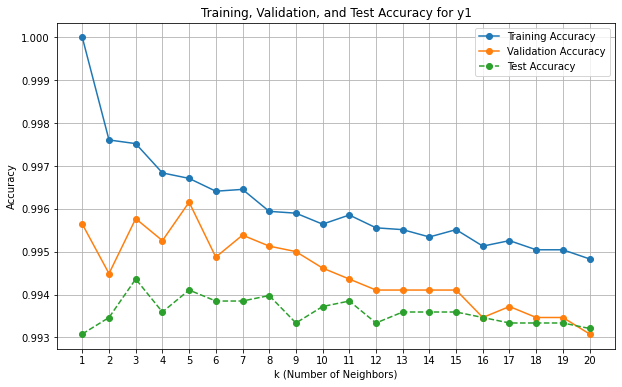

y2: Best k = 1, Validation Accuracy = 0.9991, Test Accuracy = 0.9985


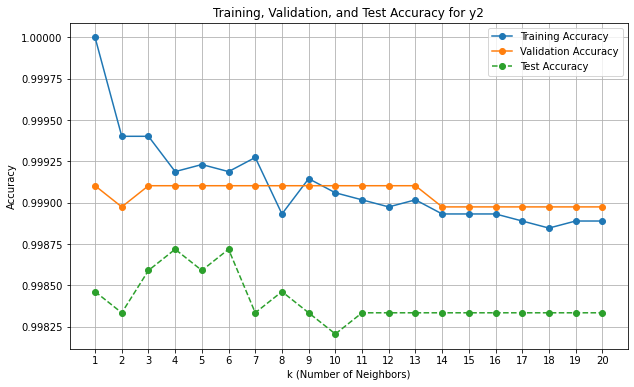

y3: Best k = 5, Validation Accuracy = 0.9856, Test Accuracy = 0.9860


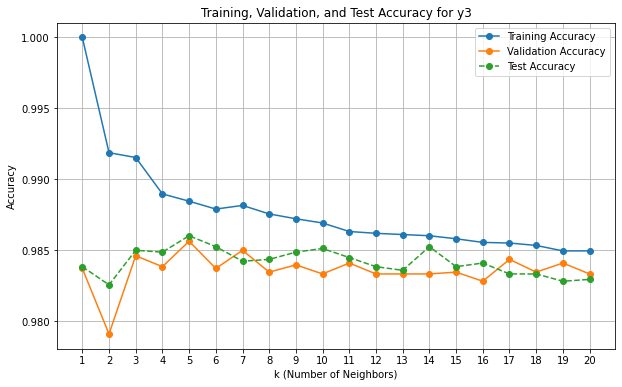

y4: Best k = 7, Validation Accuracy = 0.9758, Test Accuracy = 0.9728


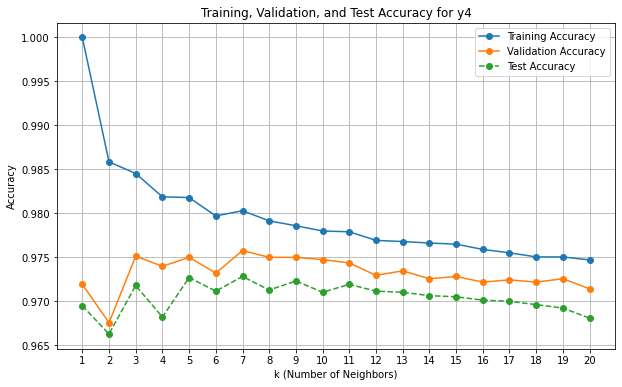

y5: Best k = 3, Validation Accuracy = 0.9735, Test Accuracy = 0.9730


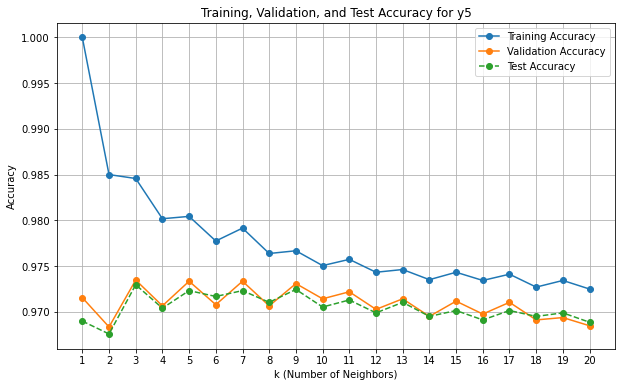

y6: Best k = 5, Validation Accuracy = 0.9713, Test Accuracy = 0.9714


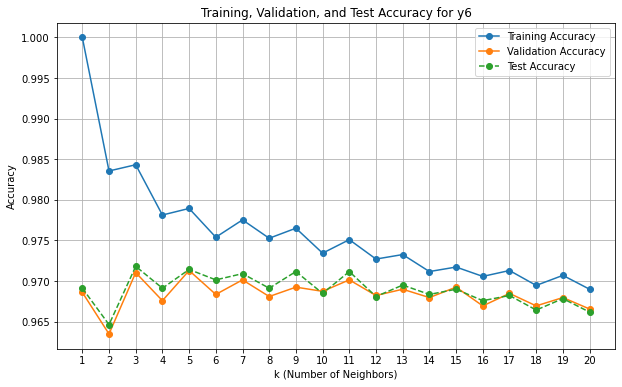

In [ ]:
y_list = [y1, y2, y3, y4, y5, y6]
k_range = range(1, 21)

for idx, y in enumerate(y_list, start=1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    train_scores = []
    val_scores = []
    test_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, knn.predict(X_train))
        val_acc = accuracy_score(y_val, knn.predict(X_val))
        test_acc = accuracy_score(y_test, knn.predict(X_test)) 
        train_scores.append(train_acc)
        val_scores.append(val_acc)
        test_scores.append(test_acc)

    best_k = k_range[np.argmax(val_scores)]
    print(f'y{idx}: Best k = {best_k}, Validation Accuracy = {max(val_scores):.4f}, Test Accuracy = {test_scores[best_k - 1]:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, train_scores, label='Training Accuracy', marker='o')
    plt.plot(k_range, val_scores, label='Validation Accuracy', marker='o')
    plt.plot(k_range, test_scores, label='Test Accuracy', marker='o', linestyle='--')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title(f'Training, Validation, and Test Accuracy for y{idx}')
    plt.legend()
    plt.grid(True)
    plt.xticks(k_range)
    plt.show()

y1: Best k = 7, PCA components = 6, Val Accuracy = 0.9967, Test Accuracy = 0.9949


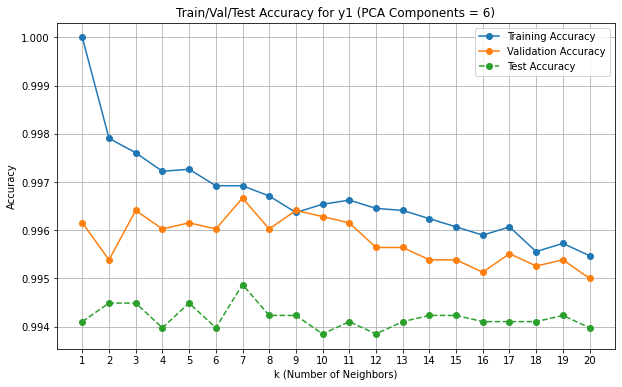

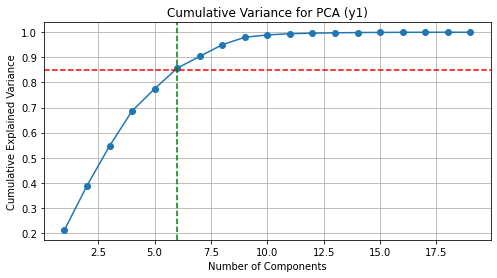

y2: Best k = 5, PCA components = 6, Val Accuracy = 0.9994, Test Accuracy = 0.9985


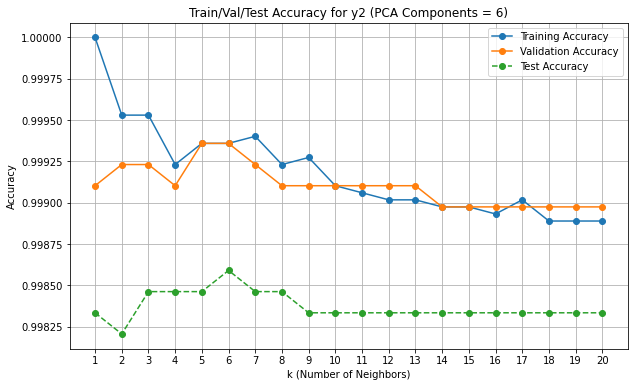

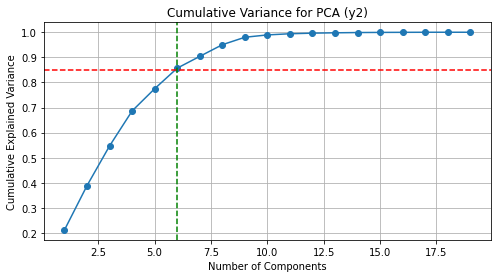

y3: Best k = 9, PCA components = 6, Val Accuracy = 0.9873, Test Accuracy = 0.9868


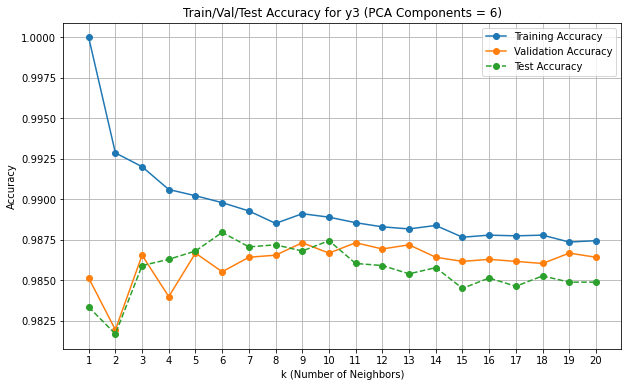

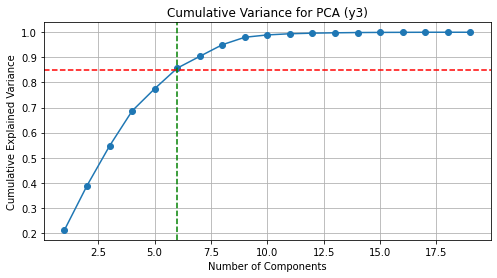

y4: Best k = 7, PCA components = 6, Val Accuracy = 0.9800, Test Accuracy = 0.9773


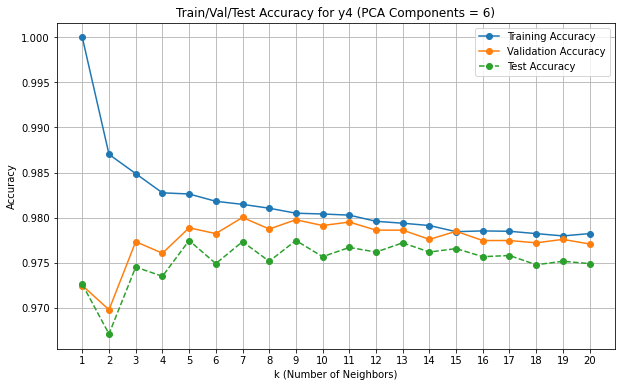

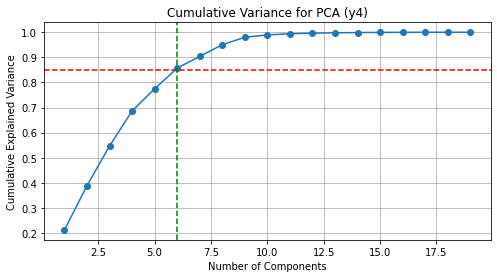

y5: Best k = 7, PCA components = 6, Val Accuracy = 0.9778, Test Accuracy = 0.9759


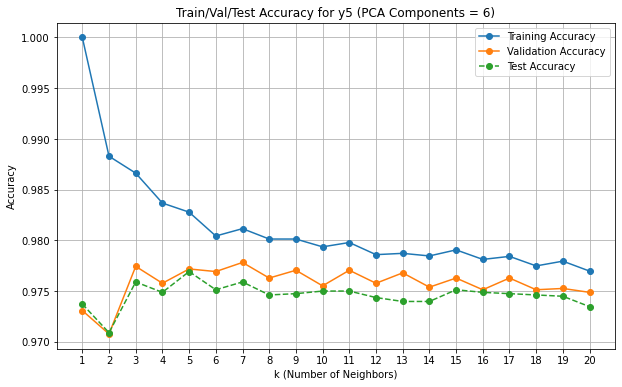

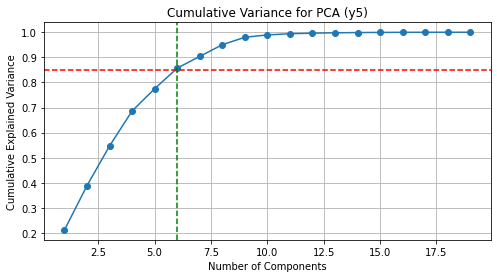

y6: Best k = 5, PCA components = 6, Val Accuracy = 0.9757, Test Accuracy = 0.9764


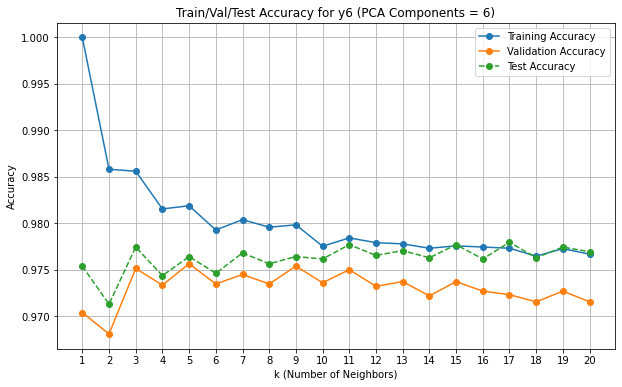

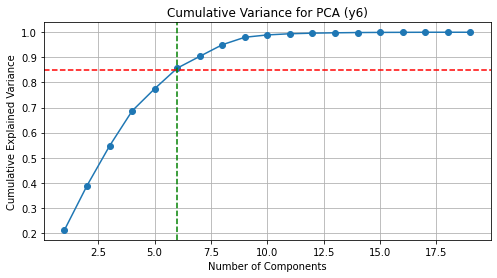

In [ ]:
k_range = range(1, 21)

for idx, y in enumerate(y_list, start=1):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    pca_full = PCA()
    pca_full.fit(X_train)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

    pca = PCA(n_components=n_components_85)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    train_scores = []
    val_scores = []
    test_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train)

        train_acc = accuracy_score(y_train, knn.predict(X_train_pca))
        val_acc = accuracy_score(y_val, knn.predict(X_val_pca))
        test_acc = accuracy_score(y_test, knn.predict(X_test_pca))

        train_scores.append(train_acc)
        val_scores.append(val_acc)
        test_scores.append(test_acc)

    best_k = k_range[np.argmax(val_scores)]
    best_val = max(val_scores)
    best_test = test_scores[best_k - 1]
    print(f'y{idx}: Best k = {best_k}, PCA components = {n_components_85}, Val Accuracy = {best_val:.4f}, Test Accuracy = {best_test:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, train_scores, label='Training Accuracy', marker='o')
    plt.plot(k_range, val_scores, label='Validation Accuracy', marker='o')
    plt.plot(k_range, test_scores, label='Test Accuracy', marker='o', linestyle='--')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title(f'Train/Val/Test Accuracy for y{idx} (PCA Components = {n_components_85})')
    plt.legend()
    plt.grid(True)
    plt.xticks(k_range)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.85, color='r', linestyle='--')
    plt.axvline(x=n_components_85, color='g', linestyle='--')
    plt.title(f'Cumulative Variance for PCA (y{idx})')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()